## Chaper 8

### building interaction datasets

Before we move onto using ML approaches to recommend items, we need to build a couple of datasets required for that purpose. 

### 1. Interaction dataframe with a measure of interest 

We will first create a dataframe with a measure of the interest on a given coupon by a given user. Such measure of interest will be, of course, based on the number of times they have purchased or visited that coupon. 

Let's go

In [1]:
import numpy as np
import pandas as pd
import os
import argparse
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from scipy.sparse import lil_matrix, csr_matrix, save_npz

inp_dir = "../datasets/Ponpare/data_processed"
out_dir = "../datasets/Ponpare/data_processed"

As usual

In [2]:
# Interactions
df_purchases_train = pd.read_pickle(os.path.join(inp_dir, 'train', 'df_purchases_train.p'))
df_visits_train = pd.read_pickle(os.path.join(inp_dir, 'train', 'df_visits_train.p'))
df_visits_train.rename(index=str, columns={'view_coupon_id_hash': 'coupon_id_hash'}, inplace=True)

# train users and coupons
df_coupons_train_feat = pd.read_pickle(os.path.join(inp_dir, 'train', 'df_coupons_train_feat.p'))
df_user_train_feat = pd.read_pickle(os.path.join(inp_dir, 'train', 'df_user_train_feat.p'))
train_users = df_user_train_feat.user_id_hash.unique()
train_coupons = df_coupons_train_feat.coupon_id_hash.unique()

# subset activities according to the users and coupons in training
df_vtr = df_visits_train[df_visits_train.user_id_hash.isin(train_users) &
    df_visits_train.coupon_id_hash.isin(train_coupons)]
df_ptr = df_purchases_train[df_purchases_train.user_id_hash.isin(train_users) &
    df_purchases_train.coupon_id_hash.isin(train_coupons)]

Remember from previous notebooks that we lose one customer (22624 --> 22623) than viewed only one coupon that is not among the training coupons and bought another coupon but not during the training period.

For purchases it will be easy, "interest" will be 1.

In [3]:
# for purchases interest will be 1
df_interest_ptr = (df_ptr
    .groupby(['user_id_hash','coupon_id_hash'])['days_to_present']
    .min()
    .reset_index())
df_interest_ptr['interest'] = 1.

df_interest_ptr.head()

user_id_hash                    coupon_id_hash  \
0  0000b53e182165208887ba65c079fc21  38beeadfe3f97e640367eddae4a8c1b5   
1  00035b86e6884589ec8d28fbf2fe7757  25a27d420caa1c46a8d3c0572d27868a   
2  0005b1068d5f2b8f2a7c978fcfe1ca06  4a79cd05ecb2bf8672e1d955f5faa7fa   
3  0005b1068d5f2b8f2a7c978fcfe1ca06  f0f66195d527a5a9509e139ed367b879   
4  000cc06982785a19e2a2fdb40b1c9d59  229ff5cc21c8d26615493be7f3b42841   

   days_to_present  interest  
0              274       1.0  
1               86       1.0  
2              310       1.0  
3              310       1.0  
4              268       1.0

Because we have already accounted for all those interactions that ended in a purchase, let's remove them from the visits table

In [4]:
# remove from the visits table those pairs user-coupon that ended up in purchases
activity_hash_p = (df_interest_ptr['user_id_hash'] + "_" +
    df_interest_ptr['coupon_id_hash']).unique()
df_vtr['activity_hash'] = (df_vtr['user_id_hash'] + "_" +
    df_vtr['coupon_id_hash'])
df_vtr = df_vtr[~df_vtr.activity_hash.isin(activity_hash_p)]
df_vtr.drop('activity_hash', axis=1, inplace=True)

/home/ubuntu/anaconda3/envs/jrz/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


For visits, "interest" will be calculated with some funcion that will depend on number of visits. Let's first calculate the number of visits

In [5]:
# for visits will depend on number of visits
df_vtr_coupon_views = (df_vtr
    .groupby(['user_id_hash','coupon_id_hash'])
    .size()
    .reset_index())
df_vtr_coupon_views.columns = ['user_id_hash','coupon_id_hash','views_count']
df_vtr_most_recent_view = (df_vtr
    .groupby(['user_id_hash','coupon_id_hash'])['days_to_present']
    .min()
    .reset_index())
df_interest_vtr = pd.merge(df_vtr_coupon_views, df_vtr_most_recent_view,
    on=['user_id_hash','coupon_id_hash'])
df_interest_vtr['interest'] = 0.
df_interest_vtr.head()

user_id_hash                    coupon_id_hash  \
0  0000b53e182165208887ba65c079fc21  0645faa156f34104e6d8910160868f9f   
1  0000b53e182165208887ba65c079fc21  18097cd25ab6b7e8eb0481b0e3a3cfd8   
2  0000b53e182165208887ba65c079fc21  1b581f2ed53f2f2eafbc1560db640194   
3  0000b53e182165208887ba65c079fc21  1d04e76c44c231d5d05dc1634d20fe8c   
4  0000b53e182165208887ba65c079fc21  2ab16b8f5aeead6d31dbdb9bd59c41db   

   views_count  days_to_present  interest  
0            1              182       0.0  
1            1              267       0.0  
2            1              182       0.0  
3            2              267       0.0  
4            2              267       0.0

Now we need to decide which function to use to compute interest based on visits. As has happened a few times already, there is a lot of freedom. Here I will use a sigmoid function and include the code for a "truncated linear" one. Please, feel free to experiment with any other function that you might consider adequate. 

Before moving into visualizing the function, let's have a look to the visits distribution

/home/ubuntu/anaconda3/envs/jrz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[(0, 10)]

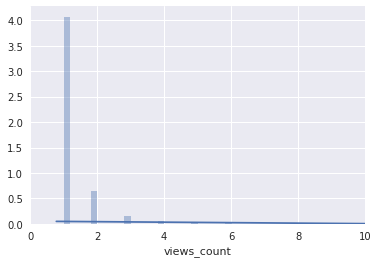

In [6]:
g = sns.distplot(df_interest_vtr.views_count, bins=5000)
g.set(xlim=(0, 10))

In [7]:
#Total number of visits:
print(df_interest_vtr.views_count.sum())
df_interest_vtr.views_count.value_counts()[:10]

1818528


1     1149969
2      180479
3       45541
4       16338
5        7073
6        3409
7        1846
8        1003
9         672
10        435
Name: views_count, dtype: int64

So $1149969/1818528 = 0.63$, 63% of the users that visited coupons visited a given coupon only once. With this information in mind, let's define our two "interest functions". 

When it comes to a sigmoid function, there are three parameters we need to define: 
1. xmid: middle point that will defines the change in trend for the S-shaped sigmoid function
2. tau: parameter that defines the slope around the middle point
3. top: parameter that defines the maximum value as x tends to infinite

For the "truncated linear", which is just a combination of two linear functions, we need to define:
1. xmid: point where the change in slope occurs
2. ylow: lower y value
3. ymid: y value where the change in slope occurs
4. ytop: upper y value

Let's visualize how these look

In [8]:
def sigmoid(x, xmid, tau, top):
    """
    Sigmoid with upper limit
    """
    return top / (1. + np.exp(-(x-xmid)/tau))


def combined_linear(x, xmid, ylow, ymid, ytop):
    """
    Truncated straight lines
    """
    m1 = (ymid-ylow)/(xmid)
    b1 = ylow

    x2 = np.max(x)
    m2 = (ytop-ymid)/(x2-xmid)
    b2 = ymid-(m2*xmid)

    x1_range = x[np.where(x<=xmid)[0]]
    x2_range = x[np.where(x>xmid)[0]]

    l1 = m1*x1_range + b1
    l2 = m2*x2_range + b2

    return np.hstack([l1,l2])


def plot_adjustment_func(x, params, xmin=None, xmax=None, func='sigmoid'):

    if not xmin: xmin = np.min(x)
    if not xmax: xmax = np.max(x)
    x = np.sort(x)

    if func == 'sigmoid':
        Z = sigmoid(x, params['xmid'], params['tau'], params['top'])
    elif func == 'linear':
        Z = combined_linear(x, params['xmid'], params['ylow'], params['ymid'], params['ytop'])

    plt.plot(x, Z, color='red', lw=0.4)
    plt.xlim((xmin, xmax))
    plt.ylabel("Interest")
    plt.show()

Let's first have a look to the modified sigmoid

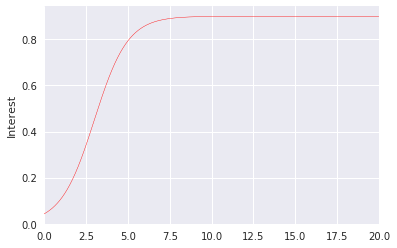

In [9]:
x = np.arange(0, 20, .01)

# This will be the actual parameters I will use
params = {'xmid': 3, 'tau': 1, 'top': 0.9} 
plot_adjustment_func(x, params)

And to the combined or "truncated" linear

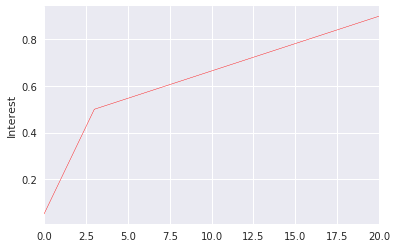

In [10]:
# Let's pick some random parameters
params = {'xmid': 3, 'ylow': 0.05, 'ymid': 0.5, 'ytop': 0.9} 
plot_adjustment_func(x, params, func='linear')

Let's concentrate on the sigmoid function since is the function that I will use throughout the notebooks. For users that only visited a coupon once, their interest in that coupon will be $\sim$0.10 (just run `sigmoid(1., 3, 1, 0.9)`). The the interest increase sharply until we get to $\sim$6 visits (Interest = 0.85). From there in advance, the Interest metric slowly increase up to 0.9, and will be never be more than that number. 

In [11]:
# interest for visits using a sigmoid
vxmid, vtau, vtop = 3, 1, 0.9
df_interest_vtr['interest'] = sigmoid(df_interest_vtr.views_count.values, vxmid, vtau, vtop)
df_interest_vtr.drop('views_count', axis=1, inplace=True)

df_interest_vtr.head()

user_id_hash                    coupon_id_hash  \
0  0000b53e182165208887ba65c079fc21  0645faa156f34104e6d8910160868f9f   
1  0000b53e182165208887ba65c079fc21  18097cd25ab6b7e8eb0481b0e3a3cfd8   
2  0000b53e182165208887ba65c079fc21  1b581f2ed53f2f2eafbc1560db640194   
3  0000b53e182165208887ba65c079fc21  1d04e76c44c231d5d05dc1634d20fe8c   
4  0000b53e182165208887ba65c079fc21  2ab16b8f5aeead6d31dbdb9bd59c41db   

   days_to_present  interest  
0              182  0.107283  
1              267  0.107283  
2              182  0.107283  
3              267  0.242047  
4              267  0.242047

In addition, a sigmoid function can also be used to compute a "recency factor". So far we have treated all coupons as equally important, independently on when they were purchased or visisted. A good recommendation algorithm should include, or at least consider, frecency. It is likely that the likes of an individual change through time so chances are that your recommendation algorithms work better if they are biased towards more recent interactions. 

Similarly to what we did with the number counts, we can use the sigmoid function above and do:

In [12]:
# in case we want to add a factor depending on recency of purchase
df_interest = pd.concat([df_interest_ptr, df_interest_vtr],
    axis=0, ignore_index=True)
df_interest['days_to_present_inv'] = df_interest.days_to_present.max() - df_interest.days_to_present

rxmid, rtau, rtop = 150, 30, 1
df_interest['recency_factor'] = sigmoid(df_interest.days_to_present_inv.values, rxmid, rtau, rtop)
df_interest.drop(['days_to_present', 'days_to_present_inv'], axis=1, inplace=True)
df_interest = df_interest.sample(frac=1).reset_index(drop=True)

df_interest.head()

user_id_hash                    coupon_id_hash  \
0  932151c9f2693452ec104958b7705b77  99307241673fa5f22e06f6336a650e28   
1  13ed03b77a5dff4b5928ca758177cbd2  8cd98a5629fbf01bbf5da144a031043b   
2  cc095ab2894d82ad847772459b4516fe  dae27665d3193f0b2f0f39e5dc249c32   
3  6af66cf5d87b20294823118182561dcc  62820076a56db9683a4c8549310819ff   
4  479ee96102411bcb0a31bc0133d80dc6  0afacf54159c4ae2a705d095108494e5   

   interest  recency_factor  
0  0.107283        0.900250  
1  0.107283        0.993082  
2  0.242047        0.903203  
3  0.107283        0.697059  
4  0.107283        0.018585

Let's save it to disk

In [56]:
# df_interest.to_pickle(os.path.join(out_dir,'train','df_interest.p'))

### 2. User-Item Interaction Matrix

Once we have the interese dataframe, building an "interaction" or "rating matrix" is straightforward. 

In [13]:
users = df_interest.user_id_hash.unique()
items = df_interest.coupon_id_hash.unique()

# user and item dictionary of indexes 
users_idx_dict = {k:v for v,k in enumerate(users)}
items_idx_dict = {k:v for v,k in enumerate(items)}

In [14]:
# lil_matrix for speed...
interactions_mtx = lil_matrix((users.shape[0], items.shape[0]))
for i, (_,row) in enumerate(df_interest.iterrows()):
    if i%100000==0:
        print('INFO: filled {} out of {} interactions'.format(i, df_interest.shape[0]))
    user_idx = users_idx_dict[row['user_id_hash']]
    item_idx = items_idx_dict[row['coupon_id_hash']]
    interest = row['interest']
    interactions_mtx[user_idx,item_idx] = interest

# ...and csr to save it (save lil format is not implemented)
interactions_mtx = 	interactions_mtx.tocsr()

INFO: filled 0 out of 1560464 interactions
INFO: filled 100000 out of 1560464 interactions
INFO: filled 200000 out of 1560464 interactions
INFO: filled 300000 out of 1560464 interactions
INFO: filled 400000 out of 1560464 interactions
INFO: filled 500000 out of 1560464 interactions
INFO: filled 600000 out of 1560464 interactions
INFO: filled 700000 out of 1560464 interactions
INFO: filled 800000 out of 1560464 interactions
INFO: filled 900000 out of 1560464 interactions
INFO: filled 1000000 out of 1560464 interactions
INFO: filled 1100000 out of 1560464 interactions
INFO: filled 1200000 out of 1560464 interactions
INFO: filled 1300000 out of 1560464 interactions
INFO: filled 1400000 out of 1560464 interactions
INFO: filled 1500000 out of 1560464 interactions


and save

In [15]:
# pickle.dump(users_idx_dict, open(os.path.join(out_dir, 'train', 'users_idx_dict.p'), 'wb'))
# pickle.dump(items_idx_dict, open(os.path.join(out_dir, 'train', 'items_idx_dict.p'), 'wb'))
# save_npz(os.path.join(out_dir, 'train', "interactions_mtx.npz"), interactions_mtx)

### 3. User and Coupon features matrices

For convenience, we will build user and coupon features matrices where the row-order is the same as that of the interaction matrix. This is not an absolutel requirement, but it will make our life easier in some of the example we go through later. 

In [19]:
# remember we lose one user that did not interact with any of the coupons in the training dataset. 
# Let's make sure all is consistent for upcoming joins:
df_user_train_feat = df_user_train_feat[df_user_train_feat.user_id_hash.isin(users_idx_dict.keys())]

Dataframes with the row/column order for users/items 

In [20]:
df_coupons_order = pd.DataFrame({'coupon_id_hash': list(items_idx_dict.keys()), 'idx': list(items_idx_dict.values())})
df_users_order = pd.DataFrame({'user_id_hash': list(users_idx_dict.keys()), 'idx': list(users_idx_dict.values())})

df_users_order.head()

user_id_hash  idx
0  932151c9f2693452ec104958b7705b77    0
1  13ed03b77a5dff4b5928ca758177cbd2    1
2  cc095ab2894d82ad847772459b4516fe    2
3  6af66cf5d87b20294823118182561dcc    3
4  479ee96102411bcb0a31bc0133d80dc6    4

Let's enforce that order

In [21]:
df_coupons_train_feat = df_coupons_train_feat.merge(df_coupons_order, on='coupon_id_hash')
df_user_train_feat = df_user_train_feat.merge(df_users_order, on='user_id_hash')

df_user_train_feat.head()

age                      user_id_hash  pref_name_cat  sex_id_cat  \
0   25  d9dca3cb44bab12ba313eaa681f663eb             47           0   
1   34  560574a339f1b25e57b0221e486907ed              2           0   
2   41  e66ae91b978b3229f8fd858c80615b73              4           1   
3   25  43fc18f32eafb05713ec02935e2c2825             47           1   
4   62  dc6df8aa860f8db0d710ce9d4839840f              5           1   

   catalog_price_mean  catalog_price_median  catalog_price_min  \
0         7200.000000                7200.0             7200.0   
1         3619.133333                3000.0              320.0   
2         2535.000000                2535.0             2535.0   
3          500.750000                   1.0                1.0   
4         8426.909091                4500.0              750.0   

   catalog_price_max  discount_price_mean  discount_price_median  \
0             7200.0          1575.000000                 1575.0   
1            12000.0          1308.666667                 1000.0   
2             2535.0          1500.000000                 1500.0   
3             2000.0           250.000000                    0.0   
4            37800.0          4198.181818                 2250.0   

   discount_price_min  discount_price_max  catalog_price_0  catalog_price_1  \
0              1575.0              1575.0              1.0              0.0   
1               160.0              4500.0              2.0              7.0   
2              1500.0              1500.0              0.0              1.0   
3                 0.0              1000.0              0.0              4.0   
4               350.0             18900.0              4.0              7.0   

   catalog_price_2  discount_price_0  discount_price_1  discount_price_2  \
0              0.0               1.0               0.0               0.0   
1              2.0               9.0               1.0               1.0   
2              0.0               1.0               0.0               0.0   
3              0.0               4.0               0.0               0.0   
4              6.0               5.0               7.0               5.0   

   top1_capsule_text_cat  top2_capsule_text_cat  top3_capsule_text_cat  \
0                      6                      6                      6   
1                      0                      8                      6   
2                      6                      6                      6   
3                      9                      9                      9   
4                      0                      6                     12   

   top1_genre_name_cat  top2_genre_name_cat  top3_genre_name_cat  \
0                    6                    6                    6   
1                    0                    8                    6   
2                    6                    6                    6   
3                    9                    9                    9   
4                    0                   11                    6   

   view_catalog_price_mean  view_catalog_price_median  view_catalog_price_min  \
0             26280.000000                    10200.0                  4480.0   
1              7375.390625                     4400.0                   920.0   
2              2600.000000                     2600.0                  2600.0   
3              2398.333333                     1560.0                  1330.0   
4              8853.020243                     5500.0                   320.0   

   view_catalog_price_max  view_discount_price_mean  \
0                 80000.0               3044.285714   
1                 44625.0               2874.140625   
2                  2600.0               1200.000000   
3                  4305.0                916.000000   
4                 61600.0               4129.080972   

   view_discount_price_median  view_discount_price_min  \
0                      1990.0                   1480.0   
1                      1997.5                    3

In [22]:
df_coupons_train_feat.sort_values('idx', inplace=True)
df_coupons_train_feat.drop(['coupon_id_hash', 'idx'], axis=1, inplace=True)
df_coupons_train_feat = df_coupons_train_feat.astype(int)

df_user_train_feat.sort_values('idx', inplace=True)
df_user_train_feat.drop(['user_id_hash', 'idx'], axis=1, inplace=True)

df_user_train_feat.head()

age  pref_name_cat  sex_id_cat  catalog_price_mean  \
13697   46             47           0         4120.500000   
9467    23              9           0        16047.459459   
21792   35             16           1         5017.062500   
15685   63              5           0         9647.205882   
11265   55             37           1         8144.034483   

       catalog_price_median  catalog_price_min  catalog_price_max  \
13697                2312.5             2000.0            13650.0   
9467                 6825.0             2000.0           104250.0   
21792                2937.5              500.0            18360.0   
15685                6405.0                1.0            46500.0   
11265                3150.0              500.0            48710.0   

       discount_price_mean  discount_price_median  discount_price_min  \
13697          1478.400000                  999.5               100.0   
9467           4017.810811                 2700.0               100.0   
21792          2161.125000                  990.0               100.0   
15685          3745.529412                 2100.0                 0.0   
11265          3346.586207                 1500.0               100.0   

       discount_price_max  catalog_price_0  catalog_price_1  catalog_price_2  \
13697              4900.0              1.0              8.0              1.0   
9467              20000.0             12.0             12.0             10.0   
21792              8990.0              3.0             10.0              2.0   
15685             14780.0              4.0             16.0             12.0   
11265             17850.0              3.0             18.0              7.0   

       discount_price_0  discount_price_1  discount_price_2  \
13697               8.0               1.0               1.0   
9467               16.0               9.0               9.0   
21792              11.0               3.0               1.0   
15685              13.0              12.0               7.0   
11265              18.0               8.0               2.0   

       top1_capsule_text_cat  top2_capsule_text_cat  top3_capsule_text_cat  \
13697                      8                      9                      6   
9467                       1                      6                      0   
21792                      6                      9                     12   
15685                     11                      0                      6   
11265                      0                     11                      9   

       top1_genre_name_cat  top2_genre_name_cat  top3_genre_name_cat  \
13697                    8                    9                    6   
9467                     1                    6                    0   
21792                    6                    9                   11   
15685                   11                    0                    6   
11265                    0                   11                    9   

       view_catalog_price_mean  view_catalog_price_median  \
13697              9991.070833                     5980.0   
9467              22718.370253                    10500.0   
21792             10938.229068                     7350.0   
15685             12531.636667                     9104.0   
11265             11129.676093                     7000.0   

       view_catalog_price_min  view_catalog_price_max  \
13697                     1.0                120000.0   
9467                   1000.0                150000.0   
21792                   500.0                112500.0   
15685                   500.0                108000.0   
11265                   500.0                 72420.0   

       view_discount_price_mean  view_discount_price_median  \
13697               4068.189583                      2480.0   
9467                6296.626582                      3316.5   
21792               4950.793049                      3400.0   
15685               5092.971111                      3550.0   

We will save the column names for later use and the matrices as csr sparse matrices

In [23]:
user_feat_mtx_colnames = df_user_train_feat.columns.tolist()
item_feat_mtx_colnames = df_coupons_train_feat.columns.tolist()

user_feat_mtx = csr_matrix(df_user_train_feat.values)
item_feat_mtx = csr_matrix(df_coupons_train_feat.values)

And finally, all to disk

In [ ]:
# pickle.dump(user_feat_mtx_colnames,
#     open(os.path.join(out_dir,'train', "user_feat_mtx_colnames.p"), "wb"))
# pickle.dump(item_feat_mtx_colnames,
#     open(os.path.join(out_dir,'train', "item_feat_mtx_colnames.p"), "wb"))

# save_npz(os.path.join(out_dir, 'train', "user_feat_mtx.npz"), user_feat_mtx)
# save_npz(os.path.join(out_dir, 'train', "item_feat_mtx.npz"), item_feat_mtx)